In [1]:
import pandas as pd
import numpy as np
import preprocessing as pp
import formatPredictions as fp
import datasets as datasets

#Importacion arboles
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier

#Importacion preprocesamiento
from sklearn.model_selection import train_test_split

#Importacion metricas
import metrics as m
from sklearn.metrics import roc_curve, auc, roc_auc_score, accuracy_score

#Librerias para visualizacion
import seaborn as sb
import matplotlib.pyplot as plt

In [2]:
df = datasets.getDataTrain()
df.head()

,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,tiene_alto_valor_adquisitivo,trabajo
0,17,Palermo,empleado_provincial,39,universidad_3_anio,sin_matrimonio,2174,hombre,40,cristianismo,sin_familia,0,entretenimiento
1,17,Palermo,monotibutista,50,universidad_3_anio,matrimonio_civil,0,hombre,13,cristianismo,casado,0,directivo_gerente
2,13,Palermo,relacion_de_dependencia,38,4_anio,divorciado,0,hombre,40,cristianismo,sin_familia,0,limpiador
3,11,Palermo,relacion_de_dependencia,53,2_anio,matrimonio_civil,0,hombre,40,judaismo,casado,0,limpiador
4,17,Balvanera,relacion_de_dependencia,28,universidad_3_anio,matrimonio_civil,0,mujer,40,judaismo,casada,0,profesional_especializado


In [3]:
df_edit = pd.DataFrame()
df_edit = df.copy()

X, y, df_new, y_encoder = pp.feature_engineering_xg_rf(df_edit)
df_new.head()

,tiene_alto_valor_adquisitivo,opera_en_bolsa,es_hombre,casado_trabajo,categoria_de_trabajo_empleado_provincial,categoria_de_trabajo_monotibutista,categoria_de_trabajo_relacion_de_dependencia,categoria_de_trabajo_responsable_inscripto,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,educacion_alcanzada_2_anio,educacion_alcanzada_3_anio,educacion_alcanzada_4_anio,educacion_alcanzada_5-6_grado,educacion_alcanzada_5_anio,educacion_alcanzada_7-8_grado,educacion_alcanzada_9_grado,educacion_alcanzada_preescolar,educacion_alcanzada_universiada_5_anio,educacion_alcanzada_universiada_6_anio,educacion_alcanzada_universidad_1_anio,educacion_alcanzada_universidad_2_anio,educacion_alcanzada_universidad_3_anio,educacion_alcanzada_universidad_4_anio,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado,estado_marital_sin_matrimonio,estado_marital_viudo_a,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a,trabajo_entretenimiento,trabajo_inspector,trabajo_limpiador,trabajo_otros,trabajo_profesional_especializado,trabajo_reparador,trabajo_sector_primario,trabajo_seguridad,trabajo_servicio_domestico,trabajo_soporte_tecnico,trabajo_transporte,trabajo_ventas
0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0
1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [4]:
print("Cantidad de features en el nuevo set")
print(len(df_new.columns))

Cantidad de features en el nuevo set
47


In [5]:
# Obtengo los sets de entrenamiento y test
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = pp.GetSeedForTrainSplit(), test_size=0.20)

In [6]:
# n_estimators es el numero de arboles
classifier=RandomForestClassifier(n_estimators=50, max_depth=5, random_state=0)

# Entrenar
classifier.fit(X_train, y_train)

# Predecir
predictions=classifier.predict(X_test)

Accuracy: 0.8232765238753262

Precision: 0.7650063856960408

Recall: 0.9628057408530423

F1 Score: 0.5100042571306939

Matriz de confusion: 
[[4763  184]
 [ 967  599]]

AUC-ROC: 



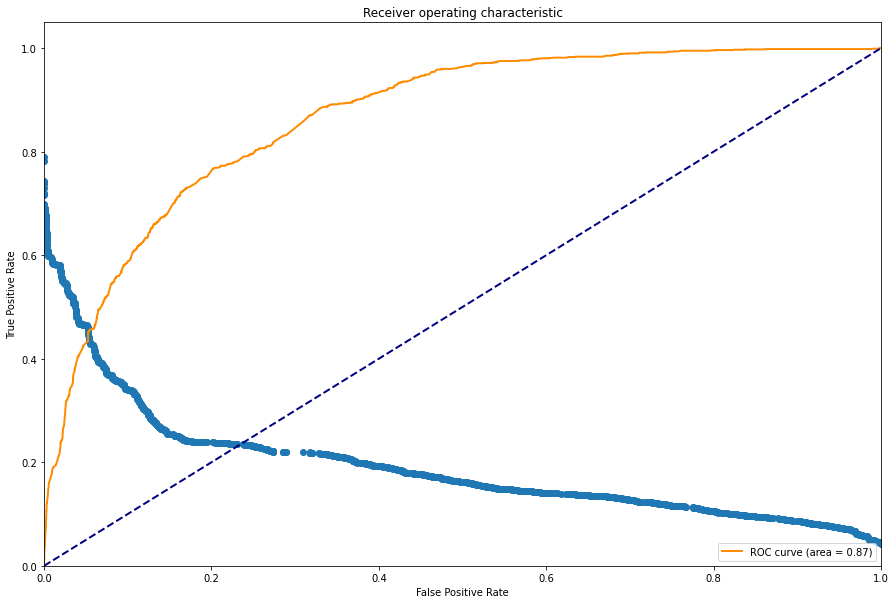

0.866290404985051

In [7]:
# Obtener metricas
m.getMetrics(y_test, predictions, classifier.predict_proba(X_test)[:,1])

In [8]:
roc_auc_score(y_test, classifier.predict_proba(X_test)[:,1])

0.866290404985051

# Analisis de features de random forest

[1.22448723e-01 5.09054262e-02 1.72652264e-01 1.25076627e-02
 1.95930759e-02 2.47840475e-02 1.65786651e-02 4.61176976e-06
 2.81265905e-04 6.72571709e-03 2.94764572e-03 1.62235827e-02
 3.17679163e-03 1.46847513e-02 6.70635469e-03 4.42402457e-03
 3.30999572e-04 1.77016556e-02 1.30499102e-02 8.21808004e-03
 7.39649333e-03 4.55573505e-02 2.98202244e-02 1.37225592e-03
 4.79697298e-03 9.09693942e-03 1.29498600e-01 7.41846661e-03
 1.86619172e-02 1.22427767e-02 3.49701311e-03 7.30498888e-03
 5.01225334e-02 2.65353060e-02 1.13383967e-02 5.97400769e-03
 5.85501878e-03 1.75664687e-02 3.68053429e-02 9.96729530e-03
 6.72569870e-03 6.55637038e-03 6.42294780e-04 1.09060640e-02
 5.71329159e-03 1.46826574e-02]


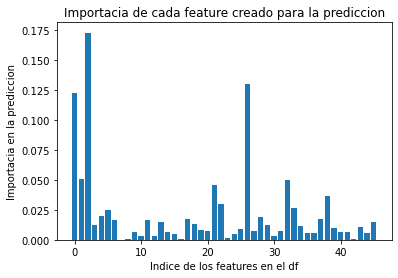

In [12]:
# Ver la importancia de cada feature para este algoritmo
model = ExtraTreesClassifier()
model.fit(X_train,y_train)

print(model.feature_importances_)

# Graficar importancia de cada uno
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.title('Importacia de cada feature creado para la prediccion', )
plt.xlabel('Indice de los features en el df')
plt.ylabel('Importacia en la prediccion')
plt.show()

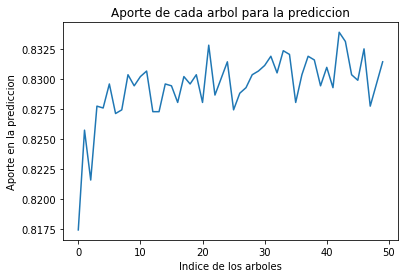

In [20]:
# Ver aporte de cada arbol
trees=range(50)
accuracy=np.zeros(50)

for idx in range(len(trees)):
    classifier=RandomForestClassifier(n_estimators=idx + 1)
    classifier=classifier.fit(X_train, y_train)
    predictions=classifier.predict(X_test)
    accuracy[idx]=accuracy_score(y_test, predictions)

plt.cla()
plt.plot(trees, accuracy)

plt.title('Aporte de cada arbol para la prediccion', )
plt.xlabel('Indice de los arboles')
plt.ylabel('Aporte en la prediccion')
plt.show()

# Prediccion sobre el archivo final

In [14]:
data_test_final = datasets.getDataValidation()
data_test_final.drop(columns = ["representatividad_poblacional"], inplace=True)
df.rename(columns={'ganancia_perdida_declarada_bolsa_argentina': 'ganancia_perdida_declarada_bolsa_argentina'}, inplace=True)
data_test_final.head()

,id,anios_estudiados,barrio,categoria_de_trabajo,edad,educacion_alcanzada,estado_marital,ganancia_perdida_declarada_bolsa_argentina,genero,horas_trabajo_registradas,religion,rol_familiar_registrado,trabajo
0,1,11,Palermo,relacion_de_dependencia,25,2_anio,sin_matrimonio,0,hombre,40,judaismo,con_hijos,inspector
1,2,13,Palermo,relacion_de_dependencia,38,4_anio,matrimonio_civil,0,hombre,50,cristianismo,casado,sector_primario
2,3,16,Palermo,empleado_municipal,28,universidad_2_anio,matrimonio_civil,0,hombre,40,cristianismo,casado,seguridad
3,4,14,Palermo,relacion_de_dependencia,44,5_anio,matrimonio_civil,7688,hombre,40,judaismo,casado,inspector
4,5,14,Palermo,NaN,18,5_anio,sin_matrimonio,0,mujer,30,cristianismo,con_hijos,NaN


In [15]:
df_test_final = pp.feature_engineering_xg_rf(data_test_final)
df_test_final.head()

,id,opera_en_bolsa,es_hombre,casado_trabajo,categoria_de_trabajo_empleado_provincial,categoria_de_trabajo_monotibutista,categoria_de_trabajo_relacion_de_dependencia,categoria_de_trabajo_responsable_inscripto,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,educacion_alcanzada_2_anio,educacion_alcanzada_3_anio,educacion_alcanzada_4_anio,educacion_alcanzada_5-6_grado,educacion_alcanzada_5_anio,educacion_alcanzada_7-8_grado,educacion_alcanzada_9_grado,educacion_alcanzada_preescolar,educacion_alcanzada_universiada_5_anio,educacion_alcanzada_universiada_6_anio,educacion_alcanzada_universidad_1_anio,educacion_alcanzada_universidad_2_anio,educacion_alcanzada_universidad_3_anio,educacion_alcanzada_universidad_4_anio,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado,estado_marital_sin_matrimonio,estado_marital_viudo_a,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a,trabajo_entretenimiento,trabajo_inspector,trabajo_limpiador,trabajo_otros,trabajo_profesional_especializado,trabajo_reparador,trabajo_sector_primario,trabajo_seguridad,trabajo_servicio_domestico,trabajo_soporte_tecnico,trabajo_transporte,trabajo_ventas
0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,2,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,4,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
len(df_test_final.columns)

47

In [17]:
df_test_final.iloc[:, 1:47].head()

,opera_en_bolsa,es_hombre,casado_trabajo,categoria_de_trabajo_empleado_provincial,categoria_de_trabajo_monotibutista,categoria_de_trabajo_relacion_de_dependencia,categoria_de_trabajo_responsable_inscripto,categoria_de_trabajo_sin_trabajo,categoria_de_trabajo_trabajo_voluntariado,educacion_alcanzada_2_anio,educacion_alcanzada_3_anio,educacion_alcanzada_4_anio,educacion_alcanzada_5-6_grado,educacion_alcanzada_5_anio,educacion_alcanzada_7-8_grado,educacion_alcanzada_9_grado,educacion_alcanzada_preescolar,educacion_alcanzada_universiada_5_anio,educacion_alcanzada_universiada_6_anio,educacion_alcanzada_universidad_1_anio,educacion_alcanzada_universidad_2_anio,educacion_alcanzada_universidad_3_anio,educacion_alcanzada_universidad_4_anio,estado_marital_matrimonio_militar,estado_marital_pareja_no_presente,estado_marital_separado,estado_marital_sin_matrimonio,estado_marital_viudo_a,religion_cristianismo,religion_judaismo,religion_otro,rol_familiar_registrado_otro,rol_familiar_registrado_sin_familia,rol_familiar_registrado_soltero_a,trabajo_entretenimiento,trabajo_inspector,trabajo_limpiador,trabajo_otros,trabajo_profesional_especializado,trabajo_reparador,trabajo_sector_primario,trabajo_seguridad,trabajo_servicio_domestico,trabajo_soporte_tecnico,trabajo_transporte,trabajo_ventas
0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [18]:
# Predecir
predictions_final=classifier.predict(df_test_final.iloc[:, 1:47])

predictions_final

array([0, 0, 1, ..., 1, 1, 1])

In [19]:
fp.exportPredictions(fp.formatPredictions(predictions_final), "predictions_final_random_forest")